# Analyse de la qualité de l'air — Notebook

Ce notebook utilise le fichier `pollution.csv` et les fonctions de `analyse.py` pour produire une analyse descriptive, des visualisations et répondre aux questions demandées.

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from analyse import analyse_complete, COLONNE_CIBLE, separer_types

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import display
import nbformat  # assure la dispo pour le rendu Plotly
from analyse import analyse_complete, COLONNE_CIBLE, separer_types

# Renderer Plotly (contournement nbformat): ouvrir dans le navigateur
pio.renderers.default = 'browser'

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximite_zones_industrielles,Densite_population,Qualite_air
0,29.800,59.100,5.200,17.900,18.900,9.200,1.720,6.300,319.000,1
1,28.300,75.600,2.300,12.200,30.800,9.700,1.640,6.000,611.000,1
2,23.100,74.700,26.700,33.800,24.400,12.600,1.630,5.200,619.000,1
3,27.100,39.100,6.100,6.300,13.500,5.300,1.150,11.100,551.000,0
4,26.500,70.700,6.900,16.000,21.900,5.600,1.010,12.700,303.000,0


In [28]:
import sys, importlib, subprocess
import plotly, plotly.io as pio

def ensure(pkg: str):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg], stdout=subprocess.DEVNULL)

for _pkg in ('nbformat', 'IPython'):
    ensure(_pkg)

import nbformat, IPython
pio.renderers.default = 'vscode'
print('Plotly:', plotly.__version__, '| nbformat:', nbformat.__version__, '| IPython:', IPython.__version__)

Plotly: 6.4.0 | nbformat: 5.10.4 | IPython: 9.7.0


## 1) Types de données, 2) Dimensions, 3) Valeurs manquantes

In [6]:
types = df_brut.dtypes.astype(str).to_frame('type')
dimensions = df_brut.shape
na_counts = df_brut.isna().sum().to_frame('valeurs_manquantes')
display(types)
print('Dimensions (lignes, colonnes):', dimensions)
display(na_counts[na_counts.valeurs_manquantes > 0])

,type
Temperature,float64
Humidity,float64
PM2.5,float64
PM10,float64
NO2,float64
SO2,float64
CO,float64
Proximite_zones_industrielles,float64
Densite_population,float64
Qualite_air,int64


Dimensions (lignes, colonnes): (5000, 10)


,valeurs_manquantes
Temperature,3
Humidity,3
PM2.5,5
PM10,4
NO2,5
SO2,1
CO,3
Densite_population,1


## 4) Remplacement des valeurs manquantes (imputation)

In [7]:
# On réutilise le pipeline de nettoyage de analyse.py (médiane pour numériques, mode pour catégorielles,
# + détection des valeurs négatives absurdes puis winsorization par IQR).
resultats = analyse_complete(csv_path)
df_net = resultats['df_net']
meta = resultats['meta']
info_avant = resultats['info_avant']
info_apres = resultats['info_apres']
print('Avant nettoyage (lignes, colonnes):', tuple(info_avant['dimensions'].iloc[0]))
print('Après nettoyage (lignes, colonnes):', tuple(info_apres['dimensions'].iloc[0]))
print("\nImputations médianes (numériques) — extrait:")
display(pd.Series(meta['imputations_medianes']).dropna().head(10))
print("\nBornes IQR (winsorization) — extrait:")
display(pd.DataFrame(meta['plafonds']).T.head(10))
df_net.head()

Avant nettoyage (lignes, colonnes): (5000, 10)
Après nettoyage (lignes, colonnes): (5000, 10)

Imputations médianes (numériques) — extrait:


Temperature                      29.000
Humidity                         69.800
PM2.5                            12.000
PM10                             21.700
NO2                              25.300
SO2                               8.100
CO                                1.410
Proximite_zones_industrielles     7.900
Densite_population              494.000
dtype: float64


Bornes IQR (winsorization) — extrait:


,bas,haut
Temperature,11.750,47.350
Humidity,25.300,113.300
PM2.5,-27.687,58.412
PM10,-26.400,76.800
NO2,2.400,49.600
SO2,-7.838,26.663
CO,-0.185,3.055
Proximite_zones_industrielles,-3.150,19.650
Densite_population,51.000,931.000


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximite_zones_industrielles,Densite_population,Qualite_air
0,29.800,59.100,5.200,17.900,18.900,9.200,1.720,6.300,319.000,1
1,28.300,75.600,2.300,12.200,30.800,9.700,1.640,6.000,611.000,1
2,23.100,74.700,26.700,33.800,24.400,12.600,1.630,5.200,619.000,1
3,27.100,39.100,6.100,6.300,13.500,5.300,1.150,11.100,551.000,0
4,26.500,70.700,6.900,16.000,21.900,5.600,1.010,12.700,303.000,0


## 6) Trois principaux contributeurs aux niveaux de pollution (PM2.5/PM10)

In [13]:
corrs = resultats['correlations']
colonnes_numeriques, _ = separer_types(df_net)
mat_spear = corrs['matrice_spearman'].loc[colonnes_numeriques, colonnes_numeriques]
top_pm25 = mat_spear['PM2.5'].drop(['PM2.5']).sort_values(ascending=False).head(3) if 'PM2.5' in mat_spear.columns else pd.Series(dtype=float)
top_pm10 = mat_spear['PM10'].drop(['PM10']).sort_values(ascending=False).head(3) if 'PM10' in mat_spear.columns else pd.Series(dtype=float)
print('Top contributeurs corrélés avec PM2.5:')
display(top_pm25)
print('Top contributeurs corrélés avec PM10:')
display(top_pm10)

Top contributeurs corrélés avec PM2.5:


PM10   0.910
CO     0.376
NO2    0.310
Name: PM2.5, dtype: float64

Top contributeurs corrélés avec PM10:


PM2.5   0.910
CO      0.583
NO2     0.482
Name: PM10, dtype: float64

## 7) Valeurs aberrantes dans PM2.5 ou PM10 (IQR)

Nombre d'outliers PM2.5 (brut): 353
Nombre d'outliers PM10 (brut): 326


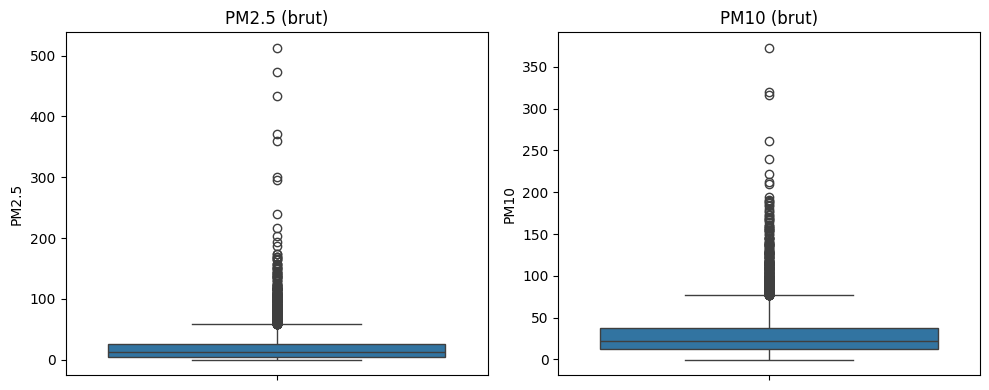

In [14]:
def detect_outliers_iqr(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    return (s < low) | (s > high)

out_pm25 = detect_outliers_iqr(df_brut['PM2.5'].dropna()) if 'PM2.5' in df_brut.columns else pd.Series(dtype=bool)
out_pm10 = detect_outliers_iqr(df_brut['PM10'].dropna()) if 'PM10' in df_brut.columns else pd.Series(dtype=bool)
print("Nombre d'outliers PM2.5 (brut):", int(out_pm25.sum()))
print("Nombre d'outliers PM10 (brut):", int(out_pm10.sum()))
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(y=df_brut['PM2.5'], ax=axes[0])
axes[0].set_title('PM2.5 (brut)')
sns.boxplot(y=df_brut['PM10'], ax=axes[1])
axes[1].set_title('PM10 (brut)')
plt.tight_layout()
plt.show()

## 8) Moyenne, médiane, écart-type des PM2.5 et PM10 (sur données nettoyées)

In [16]:
stats_pm = {}
for col in ['PM2.5', 'PM10']:
    if col in df_net.columns:
        s = df_net[col].astype(float)
        stats_pm[col] = {
            'moyenne': float(s.mean()),
            'mediane': float(s.median()),
            'ecart_type': float(s.std(ddof=1))
        }
display(pd.DataFrame(stats_pm))

,PM2.5,PM10
moyenne,18.023,28.226
mediane,12.000,21.700
ecart_type,17.230,20.612


## 9) Corrélation entre l'humidité et la qualité de l'air

Rho de Spearman(Humidity, Qualite_air): 0.603


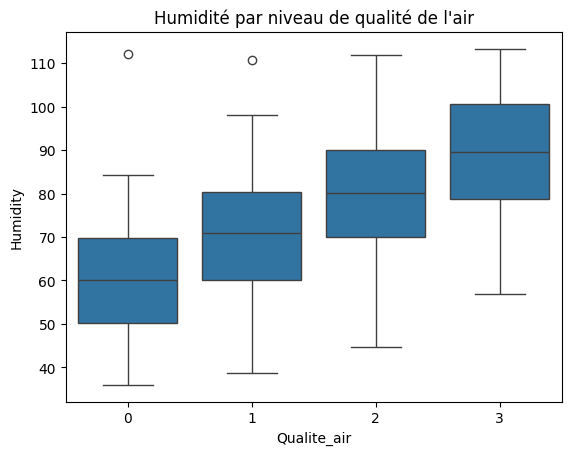

In [25]:
if 'Humidity' in df_net.columns and COLONNE_CIBLE in df_net.columns:
    y_codes = df_net[COLONNE_CIBLE].cat.codes if hasattr(df_net[COLONNE_CIBLE], 'cat') else df_net[COLONNE_CIBLE]
    rho = pd.Series(df_net['Humidity']).corr(pd.Series(y_codes), method='spearman')
    print(f'Rho de Spearman(Humidity, {COLONNE_CIBLE}): {rho:.3f}')
    sns.boxplot(data=df_net, x=COLONNE_CIBLE, y='Humidity')
    plt.title('Humidité par niveau de qualité de l\'air')
    plt.show()
else:
    print('Colonnes nécessaires manquantes.')

## 11) Quartiles des concentrations de CO

In [22]:
if 'CO' in df_net.columns:
    qs = df_net['CO'].quantile([0.25, 0.5, 0.75])
    display(qs.to_frame('quantiles_CO'))
else:
    print('Colonne CO manquante.')

,quantiles_CO
0.250,1.030
0.500,1.410
0.750,1.840


## Matrice de corrélations (Spearman) — aperçu visuel

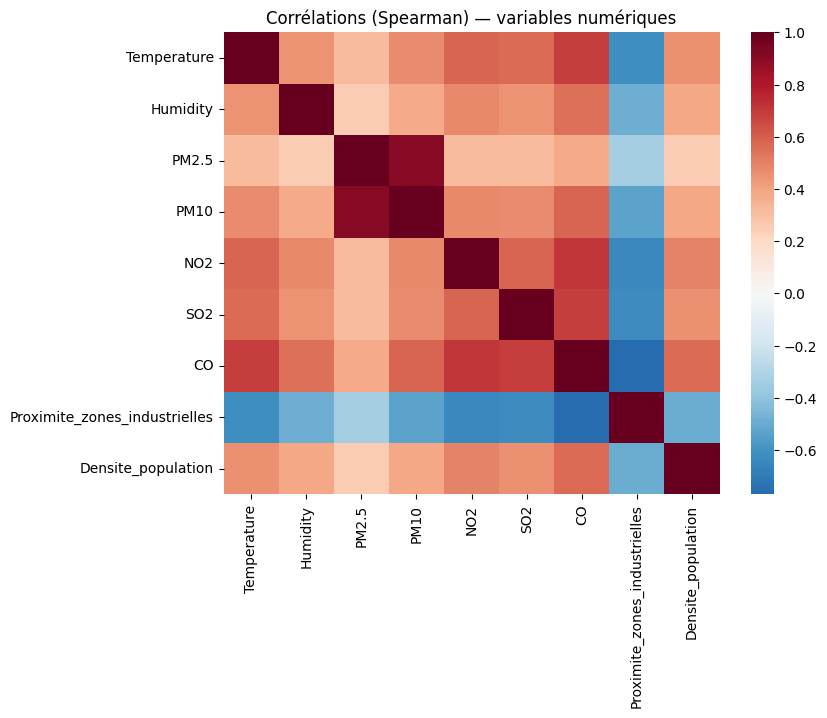

In [21]:
colonnes_numeriques, _ = separer_types(df_net)
mat = df_net[colonnes_numeriques].corr(method='spearman').round(2)
plt.figure(figsize=(8,6))
sns.heatmap(mat, annot=False, cmap='RdBu_r', center=0)
plt.title('Corrélations (Spearman) — variables numériques')
plt.show()

## Synthèse rapide
- Les types, dimensions et valeurs manquantes sont listés ci-dessus.
- Les valeurs manquantes sont imputées par médiane (numériques) et mode (catégorielles).
- Les variables les plus liées à la qualité de l'air sont présentées par information mutuelle.
- Les principaux contributeurs corrélés avec PM2.5/PM10 sont listés.
- Outliers détectés via IQR, statistiques descriptives fournies pour PM2.5/PM10.
- Humidité vs qualité: rho de Spearman + boxplot.
- Densité de population vs PM2.5: corrélation et nuage de points avec tendance.
- Quartiles de CO reportés.

## Réponse 5) Facteurs les plus corrélés avec la qualité de l'air

Les facteurs les plus informatifs vis-à-vis de `Qualite_air` sont listés ci-dessous (Information Mutuelle calculée sur les données nettoyées).

In [ ]:
imp = resultats['importance_variables'] if 'importance_variables' in resultats else None
if imp is None or imp.empty:
    print("Importance des variables indisponible.")
else:
    display(imp.head(15))
    try:
        import plotly.express as px
        fig = px.bar(imp.head(15), x='variable', y='information_mutuelle', title="Top variables (Information Mutuelle) vs Qualite_air")
        fig.update_layout(xaxis_title='Variable', yaxis_title='Information mutuelle')
        fig.show()
    except Exception as e:
        print("Plotly indisponible, affichage tableau seulement.", e)

## Réponse 10) Lien entre la densité de population et les niveaux de PM2.5

Corrélation de Spearman calculée sur les données nettoyées (`df_net`) et visualisation par nuage de points.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if 'df_net' in globals() and 'Densite_population' in df_net.columns and 'PM2.5' in df_net.columns:
    rho = pd.Series(df_net['Densite_population']).corr(pd.Series(df_net['PM2.5']), method='spearman')
    print(f"Spearman(Densite_population, PM2.5) = {rho:.3f}")
    try:
        import plotly.express as px
        fig = px.scatter(df_net, x='Densite_population', y='PM2.5', title='Densité de population vs PM2.5', trendline=None)
        fig.show()
    except Exception:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=df_net, x='Densite_population', y='PM2.5', s=15, alpha=0.6)
        plt.title('Densité de population vs PM2.5')
        plt.tight_layout()
        plt.show()
else:
    print("Colonnes nécessaires manquantes pour la corrélation.")